# Arabic Dialect Identification system

**Arabic dialect identification is the task of determining the dialect of a given Arabic text. This is a challenging task due to the high variability of Arabic dialects and the lack of large-scale datasets annotated with dialect information.**



# Import Libraries

In [2]:
!pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 683.4 kB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import pandas as pd
import numpy as np
import re
import nltk

nltk.download('wordnet')
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pyarabic.araby as araby

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize


[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load Dataset

**Messages Dataset:**

Data contains tweets in different Arabic dialects.

In [5]:
# Load messages dataset
tweets = pd.read_csv('/content/drive/My Drive/messages.csv',lineterminator='\n')
tweets.columns = ['id','tweets']
tweets

,id,tweets
0,1.175358e+18,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1.175416e+18,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1.175450e+18,@KanaanRema مبين من كلامه خليجي
3,1.175471e+18,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1.175497e+18,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺
...,...,...
458656,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...
458657,1.055620e+18,@MahmoudWaked7 @maganenoo في طريق مطروح مركز ب...
458658,NaN,0
458659,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...


**Dialect Dataset:**

Data contains the dialect (labels) of the tweets.

In [6]:
# Load dialect dataset
dialects = pd.read_csv('/content/drive/My Drive/dialect_dataset.csv',lineterminator='\n')
dialects

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ
3,1175471073770573824,IQ
4,1175496913145217024,IQ
...,...,...
458192,1019484980282580992,BH
458193,1021083283709407232,BH
458194,1017477537889431552,BH
458195,1022430374696239232,BH


# Data processing

In [7]:
# Marge tweets and dialects datasets in one dataframe
data = pd.merge(tweets, dialects, on='id')

# drop the id columns
data = data.drop(columns=['id'])

data.head()
# As shown here the data needs to be really cleaned and to exlude users accounts and other useless symbols and emojies

,tweets,dialect
0,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,@KanaanRema مبين من كلامه خليجي,IQ
3,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ


In [8]:
data[data['dialect'] == 'IQ']

,tweets,dialect
0,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,@KanaanRema مبين من كلامه خليجي,IQ
3,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ
...,...,...
15492,@sally6337g انتخبي واحد بعمرة ممصلي اشرف من قا...,IQ
15493,@khatona_Ba فدوه خاتون .......ماعندج نعال لاست...,IQ
15494,#سد_اليسو حكومتنا حكومة ارشاد ونصح فقط مثل الم...,IQ
15495,@smih416 الانوثه اقوى سلاح دمار شامل للاعصاب,IQ


**Dialect names**

In [9]:
# Display the dialect names
dialect_names = data['dialect'].unique()
print(dialect_names)

['IQ' 'LY' 'QA' 'PL' 'SY' 'TN' 'JO' 'MA' 'SA' 'YE' 'DZ' 'EG' 'LB' 'KW'
 'OM' 'SD' 'AE' 'BH']


**Convert dialectal Arabic names to full country names**

In [10]:
# Define a dictionary that maps dialectal Arabic names to full country names
short_to_full = {
    'EG': 'مصري',
    'DZ': 'جزائري',
    'TN': 'تونسي',
    'LY': 'ليبي',
    'MA': 'مغربي',
    'JO': 'اردني',
    'LB': 'لبناني',
    'PL': 'فلسطيني',
    'SY': 'سوري',
    'IQ': 'عراقي',
    'KW': 'كويتي',
    'SA': 'سعودي',
    'AE': 'اماراتي',
    'OM': 'عماني',
    'QA': 'قطري',
    'YE': 'يمني',
    'SD': 'سوداني',
    'BH': 'بحريني'
}
# Define a function that converts the short names to full names
def convert_name(name):
    return short_to_full[name]

# Convert dialectal Arabic names to full country names
data['dialect'] = data['dialect'].apply(convert_name)

data

,tweets,dialect
0,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,عراقي
1,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,عراقي
2,@KanaanRema مبين من كلامه خليجي,عراقي
3,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,عراقي
4,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,عراقي
...,...,...
458196,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅,بحريني
458197,@Zzainabali @P_ameerah والله ماينده ابش يختي,بحريني
458198,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...,بحريني
458199,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,بحريني


In [11]:
import re

# Iterate over each tweet in the 'Tweets' column
for i, sent in enumerate(data['tweets']):
    # Apply regular expression substitution to remove alphanumeric characters, hashtags, and URLs
    data.iloc[i:i+1, 0] = re.sub('[a-zA-Z0-9_]|#|http\S+', '', sent)



In [12]:
for i, sent in enumerate(data['tweets']):
    # remove old style retweet text "RT"
    data.iloc[i:i+1, 0] = re.sub(r'^RT[\s]+', '', sent)

    # remove hyperlinks
    data.iloc[i:i+1, 0] = re.sub(r'https?://[^\s\n\r]+', '', sent)

    # remove hashtags and mentions, only removing the hash # sign from the word and the @ sign
    data.iloc[i:i+1, 0] = re.sub(r'#', '', sent)
    data.iloc[i:i+1, 0] = re.sub(r'@', '', sent)



In [13]:
import unicodedata as ud

# Iterate over each tweet in the 'Tweets' column of
for i, sent in enumerate(data['tweets']):
    # Apply Unicode category-based filtering to remove punctuation characters
    data.iloc[i:i+1, 0] = ''.join(c for c in sent if not ud.category(c).startswith('P'))

In [14]:
# remove non word or spaces (punctuation & emojis)
for i, sent in enumerate(data['tweets']):
    data.iloc[i:i+1, 0] = re.sub(r'[^\w\s]', ' ', sent)

In [15]:
# stop words file that contains the most common arabic stop words
with open('Stop_Words.txt', 'r', encoding="utf-8") as f:
    stopwords = f.readlines()
    stop_set = set(m.strip() for m in stopwords)
    stop_words = list(frozenset(stop_set))

In [16]:
!pip install nltk

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
# Iterate over each tweet in the 'Tweets' column
for i, sent in enumerate(data['tweets']):
    # Tokenize the tweet into words
    tokens = nltk.word_tokenize(sent)
    # Filter out stopwords from the tokens
    data.iloc[i:i+1, 0] = ' '.join(token for token in tokens if not token in stop_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
# remove extra spaces
for i, sent in enumerate(data['tweets']):
    data.iloc[i:i+1, 0] = " ".join(sent.split())
    data.iloc[i:i+1, 0]=re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD.0-9]+', ' ', sent) # تحذف الاشياء الغير عربية


In [19]:
data.isnull().sum() # check nulls

tweets     0
dialect    0
dtype: int64

# Data Modeling

In [20]:
summarizedDialects=data.copy()

In [21]:
data['dialect'].value_counts() #before

مصري       57640
فلسطيني    43742
كويتي      42109
ليبي       36499
قطري       31069
اردني      27921
لبناني     27617
سعودي      26832
اماراتي    26296
بحريني     26292
عماني      19116
سوري       16242
جزائري     16183
عراقي      15497
سوداني     14434
مغربي      11539
يمني        9927
تونسي       9246
Name: dialect, dtype: int64

In [22]:
# filter dialects
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'يمني'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'جزائري'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'قطري'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'بحريني'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'تونسي'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'اردني'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'اماراتي'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'عراقي'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'عماني'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'فلسطيني'].index, inplace = True)
summarizedDialects.drop(summarizedDialects[summarizedDialects['dialect'] == 'ليبي'].index, inplace = True)

In [23]:
summarizedDialects['dialect'].value_counts() #after

مصري      57640
كويتي     42109
لبناني    27617
سعودي     26832
سوري      16242
سوداني    14434
مغربي     11539
Name: dialect, dtype: int64

In [24]:
summarizedDialects[summarizedDialects['dialect'] == 'سعودي'].head()

,tweets,dialect
191755,سعيد قررت اروح تركيا يومين وبعدين المغرب شهرين,سعودي
191756,الله يسمع منك ياصبي الهيلا بس قرقاش ذا قام يقر...,سعودي
191757,ابراي الله بس خلينا نخفف اللهجة شوي تري تعليمن...,سعودي
191758,مو ياخوي حنا كنا اخوان ونقرقش لبعض وش صار,سعودي
191759,يعني بنكمل وحنا ناقصين لاعب بننهي الحرب علي فك...,سعودي


In [25]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split



### LinearSVC
LinearSVC can be used for multi-class classification by using one-vs-all or one-vs-rest strategies. The one-vs-all strategy creates a separate SVM for each class, and the one-vs-rest strategy creates a single SVM that learns to distinguish between each class and the rest of the classes.

Overall, LinearSVC is a fast and accurate algorithm for training linear SVMs for large-scale multi-class classification problems.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(summarizedDialects.tweets, summarizedDialects.dialect, test_size=.2,train_size=0.8, stratify=summarizedDialects.dialect, random_state=42)

vec = CountVectorizer()
clf = LinearSVC()
pipe = make_pipeline(vec, clf)
pipe.fit(x_train, y_train)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('linearsvc', LinearSVC())])

In [27]:
x_test.shape

(39283,)

In [28]:
from sklearn import metrics

def print_report(pipe, x_test, y_test):
    y_pred = pipe.predict(x_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe, x_test, y_test)

              precision    recall  f1-score   support

       سعودي       0.59      0.58      0.59      5366
      سوداني       0.69      0.59      0.64      2887
        سوري       0.52      0.45      0.49      3248
       كويتي       0.71      0.75      0.73      8422
      لبناني       0.70      0.73      0.72      5524
        مصري       0.83      0.89      0.86     11528
       مغربي       0.79      0.64      0.71      2308

    accuracy                           0.72     39283
   macro avg       0.69      0.66      0.67     39283
weighted avg       0.72      0.72      0.72     39283

accuracy: 0.721


In [29]:
# Model Accuracy Enhancements
ngram_range=[1,1,2,3,5]

for i,j in zip(ngram_range,ngram_range[1:]):
    print(f"For N-Gram range = ({i,j})")
    vec = TfidfVectorizer( ngram_range=(i, j))
    clf_svc = LinearSVC()
    pipe_tfidf = make_pipeline(vec, clf_svc)
    pipe_tfidf.fit(x_train, y_train)
    print_report(pipe_tfidf, x_test , y_test)
    print('#'*60)
    print('\n'*2)

For N-Gram range = ((1, 1))
              precision    recall  f1-score   support

       سعودي       0.63      0.61      0.62      5366
      سوداني       0.78      0.60      0.68      2887
        سوري       0.61      0.44      0.51      3248
       كويتي       0.71      0.80      0.75      8422
      لبناني       0.74      0.77      0.76      5524
        مصري       0.84      0.92      0.88     11528
       مغربي       0.86      0.66      0.75      2308

    accuracy                           0.75     39283
   macro avg       0.74      0.69      0.71     39283
weighted avg       0.75      0.75      0.75     39283

accuracy: 0.752
############################################################



For N-Gram range = ((1, 2))
              precision    recall  f1-score   support

       سعودي       0.66      0.61      0.64      5366
      سوداني       0.81      0.59      0.68      2887
        سوري       0.67      0.41      0.51      3248
       كويتي       0.71      0.82      0.76      8

In [30]:
# best score for LinearSVC model
from sklearn.naive_bayes import MultinomialNB
vec = TfidfVectorizer(ngram_range=(1, 2))
clf = LinearSVC()
pipe_tfidf = make_pipeline(vec, clf)
pipe_tfidf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('linearsvc', LinearSVC())])

### Cross-validation for LinearSVC

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_tfidf, x_train, y_train, cv=10)
print("CV average score: %.2f" % scores.mean())


In [34]:
deployment_pipeline = pipe_tfidf
print_report(pipe_tfidf, x_test, y_test)


              precision    recall  f1-score   support

       سعودي       0.66      0.61      0.64      5366
      سوداني       0.81      0.59      0.68      2887
        سوري       0.67      0.41      0.51      3248
       كويتي       0.71      0.82      0.76      8422
      لبناني       0.75      0.79      0.77      5524
        مصري       0.83      0.93      0.88     11528
       مغربي       0.89      0.66      0.76      2308

    accuracy                           0.76     39283
   macro avg       0.76      0.69      0.71     39283
weighted avg       0.76      0.76      0.75     39283

accuracy: 0.759


In [35]:

# كل الجمهور يهال
# ولك بيكون برا الهواء تلج
# كل الجمهور بزران
text = ["داير فول وكشري"]
# text = [preprocessing.processing(x) for x in text]
print(text)
y_pred = deployment_pipeline.predict(text)
for i in range(len(text)):
    print(f'{text[i]} --> {[y_pred[i]]}')

['داير فول وكشري']
داير فول وكشري --> ['سوداني']


# Logistic Regression
Logistic regression has multiple advantages such as easy to implement,very efficient to train,It can easily extend to multiple classes, and it is less inclined to over-fitting.

In [36]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

LR = LogisticRegression(max_iter=250)
Xtrain, Xtest, ytrain, ytest = train_test_split(summarizedDialects.tweets, summarizedDialects.dialect, test_size = 0.3, random_state = 0)


In [37]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

LR = LogisticRegression(max_iter=250)
xtrain, xtest, ytrain, ytest = train_test_split(summarizedDialects.tweets, summarizedDialects.dialect, test_size = 0.3, random_state = 0)
#first instantiate the tranformer, we use TfidfVectorizer in this case
tfidf_vectorizer = TfidfVectorizer()
#tokenize and build vocab
tfidf_vectorizer.fit(xtrain)
#transform the training data
xtrain_tfidf = tfidf_vectorizer.transform(xtrain)
#summarize
print(tfidf_vectorizer.get_feature_names_out())

['ءرءتو' 'ءه' 'ءو' ... 'ﻻﻧﻪ' 'ﻻﻧﻬﺎ' 'ﻻﻫﺎﻥ']


In [38]:
#encode document
X_train_tfidf = tfidf_vectorizer.transform(Xtrain)
LR.fit( X_train_tfidf, ytrain)
X_test_tfidf = tfidf_vectorizer.transform(Xtest)
pred = LR.predict(X_test_tfidf)
Log_acc = accuracy_score(ytest, pred)
print(Log_acc)
print(classification_report(ytest, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7377129862195371
              precision    recall  f1-score   support

       سعودي       0.63      0.57      0.60      8065
      سوداني       0.87      0.52      0.65      4367
        سوري       0.71      0.37      0.49      4770
       كويتي       0.65      0.83      0.73     12602
      لبناني       0.75      0.75      0.75      8425
        مصري       0.80      0.93      0.86     17257
       مغربي       0.91      0.61      0.73      3438

    accuracy                           0.74     58924
   macro avg       0.76      0.65      0.69     58924
weighted avg       0.74      0.74      0.73     58924



# RNN-GRU
 It is easier to train and less prone to overfitting. GRU is a good choice for tasks that require the network to learn quickly and adapt to new inputs. In this case, the network is being trained to classify texts according to their dialect. This is a task that requires the network to learn long-range dependencies, which GRU is well-suited for.

In [39]:
#Extracts the voc_size
def unq_words(sentence):
    unq_words_list = []
    for sent in (sentence):
        for word in sent.split():
            if word.lower() not in unq_words_list:
                unq_words_list.append(word.lower())
            else:
                pass
    return unq_words_list

unique_words = unq_words(summarizedDialects.tweets)
print("Total unique words present :", len(unique_words))

In [40]:
VOC_SIZE = 311678

onehot_vector = [one_hot(words, VOC_SIZE) for words in summarizedDialects.tweets]
SENTENCE_LENGTH = 67
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

In [41]:
#splitting
train_data, test_val_data, train_labels, test_val_labels = train_test_split(embedded_docs, summarizedDialects.dialect, test_size=0.2, random_state=42, stratify=summarizedDialects.dialect)
val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels)



In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
val_labels = label_encoder.fit_transform(val_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=7)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=7)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=7)

In [43]:
VECTOR_FEATURES = 128

gru_bi = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(VOC_SIZE, VECTOR_FEATURES),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
gru_bi.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = gru_bi.fit(train_data, train_labels, epochs=10, batch_size=128,
                    steps_per_epoch= 100,
                    validation_data=(val_data, val_labels),
                    validation_steps=100)

In [44]:
model_acc, model_loss = gru_bi.evaluate(test_data, test_labels)

print('Test Loss: {}'.format(model_acc))
print('Test Accuracy: {}'.format(model_loss))


In [45]:
preds_valid = gru_bi.predict(test_data)

pred_labels = np.argmax(preds_valid, axis=-1)

In [46]:
# Convert predicted labels to multilabel-indicator format
pred_labels = label_binarize(pred_labels, classes=np.arange(7))

# Calculate F1 score
f1_macro = f1_score(test_labels, pred_labels, average='macro')

print(f1_macro)
def predict(text, clf, word2idx, padding_size):
    # padd the text
    padded_text = np.zeros((padding_size))
    # transform your text into indices
    padded_text[:min(padding_size, len(text.split()))] = [
        word_to_index.get(word, 0) for word in text.split()][:padding_size]
    # predict it !
    prediction = clf.predict(tf.expand_dims(padded_text, 0))
    return prediction
words = summarizedDialects['tweets'].apply(lambda x: text_to_word_sequence(x))

word_to_index = {}
for word_list in words:
    for word in word_list:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

In [47]:
text= " الجمهور يهال"
mapping = {'0':'سعودي',
           '1':'سوداني',
          '2':'سوري',
          '3':'كويتي',
          '4':'لبناني',
          '5':'مصري',
          '6':'مغربي'}

rnn_padding = 50
out_GRU = predict(text, gru_bi, word_to_index, rnn_padding)

out_GRU = np.argmax(out_GRU)
print(mapping[str(out_GRU)])

# Compare Models

In [48]:
from plotly import express as ex

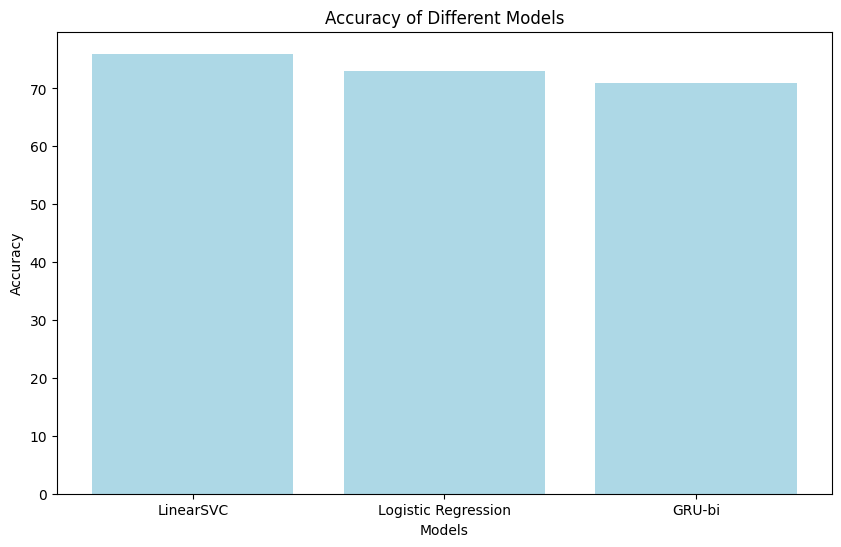

In [49]:
import matplotlib.pyplot as plt

models = ['LinearSVC', 'Logistic Regression', 'GRU-bi']
accuracy = [76.0, 73.0, 71.0]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='lightblue')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")
plt.show()


# Model deployment

In [50]:
# !pip install pyTelegramBotAPI

In [51]:
import pickle

In [52]:
with open("pipeline.pkl", "wb") as f:
    pickle.dump(deployment_pipeline,f)

In [53]:
f.close()

In [54]:
with open("pipeline.pkl", "rb") as f:
  pipe_tfidf = pickle.load(f)


In [55]:
!pip install --upgrade python-telegram-bot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00


In [56]:
!pip install telebot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.13.0-py3-none-any.whl size=214529 sha256=8a927ea6d9c303c277d146fd0e783ab578bdf956f72fc05d960237f1bfb997b6
  Stored in directory: /root/.cache/pip/wheels/f7/1a/3b/41e1ce64625e3f11567085dc79043d9fa573a2cc39f9938556
Successfully built pyTelegramBotAPI


In [57]:
import telebot
BOT_TOKEN = '6572809263:AAGRihXPMgo-onH7a-A62ba7InRuT9OSVfY'
bot = telebot.TeleBot(BOT_TOKEN)

In [58]:
@bot.message_handler(commands=['start', 'hello'])
def send_welcome(message):
    bot.reply_to(message, "اهلا, من فضلك ادخل النص المراد التعرف على اللهجة الخاصة به")




@bot.message_handler(content_types=['text'])
def predict_dialect(message):
  text = message.text
  # text = [preprocessing.processing(x) for x in text]
  y_pred = pipe_tfidf.predict([text])
  for i in range(len(y_pred)):
    if message.chat.id:
      bot.reply_to(message, f'{text} --> {y_pred[i]}')
bot.infinity_polling()

2023-09-13 23:05:18,731 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-09-13 23:05:18,734 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling
